# Draft_01

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Authors:** António Cruz (140129), Ricardo Kayseller (95813)

## 1. Environment Setup

---

In [1]:
# Import required dependencies
import numpy as np
import os

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

In [2]:
# Set global variables
SEED = 42

DATASET_PATH = "../../dataset/"

BATCH_SIZE = 128
LATENT_DIM = 100
NUM_CLASSES = 10

NUM_STEPS = 15005
SAVE_INTERVAL = 1000

MODEL_OUTPUT_PATH = "model/"
D_MODEL_NAME = "D_DRAFT_01"
G_MODEL_NAME = "G_DRAFT_01"

NUM_EVAL_SAMPLES = 10000

In [3]:
# Set random seeds for reproducibility across both numpy and pytorch
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading

---

In [5]:
# Transform: convert PIL image to tensor (scales [0,255] to [0,1]),
# then normalize to [-1, 1] range using mean=0.5, std=0.5
# Formula: (x - 0.5) / 0.5 = 2x - 1, which maps [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from a local folder
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

# DataLoader handles batching, shuffling, and parallel loading
# drop_last=True discards the final incomplete batch so every batch has exactly BATCH_SIZE samples
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Batches per epoch: 468


## 3. Generator

---

In [ ]:
class Generator(nn.Module):

    def __init__(self, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES):

        super().__init__()

        # Embed the class label into a vector of the same size as z: input_dim=10, output_dim=latent_dim
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        # Main sequential network that transforms the conditioned noise into an image
        self.model = nn.Sequential(
            # Dense layer: latent_dim → 128*7*7
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),

            # Reshape handled via forward(); here we continue from (128, 7, 7)

            # First upsample block: (128, 7, 7) → (128, 14, 14)
            nn.Upsample(scale_factor=2),
            # Conv2D(128, 3, padding='same', activation='relu')
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128, momentum=0.8),

            # Second upsample block: (128, 14, 14) → (128, 28, 28)
            nn.Upsample(scale_factor=2),
            # Conv2D(64, 3, padding='same', activation='relu')
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64, momentum=0.8),

            # Output layer: (64, 28, 28) → (1, 28, 28), tanh maps to [-1, 1]
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Embed the label and multiply element-wise with z (multiplicative conditioning)
        label_embed = self.label_embedding(labels).squeeze(1)  # (batch, latent_dim)
        conditioned = z * label_embed                           # (batch, latent_dim)

        # Pass through the dense layer, then reshape to (batch, 128, 7, 7) for the conv layers
        x = self.model[0](conditioned)  # Linear
        x = self.model[1](x)            # ReLU
        x = x.view(-1, 128, 7, 7)

        # Pass through the remaining conv/upsample layers
        x = self.model[2:](x)
        return x


# Instantiate and move to device
g_model = Generator().to(device)
print(g_model)

Generator(
  (label_embedding): Embedding(10, 100)
  (model): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (6): Upsample(scale_factor=2.0, mode='nearest')
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (10): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
  )
)


# 4. Discriminator

---

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        
        super().__init__()

        # Embed the class label into a vector of size 28*28:
        # One full image channel (input_dim=10, output_dim=784)
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network that classifies the concatenated input
        self.model = nn.Sequential(
            # Input is (2, 28, 28): image channel + label channel
            # Conv2D(32, 3, stride=2, padding='same') — stride 2 halves spatial dims to 14x14
            nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Second conv block: (32, 14, 14) → (64, 7, 7)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Flatten: (64, 7, 7) → (64*7*7) = (3136)
            nn.Flatten(),

            # Dense(512, activation='relu')
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.25),

            # Output: single probability, sigmoid maps to [0, 1]
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed label to 784 dims, reshape to a spatial map (1, 28, 28)
        label_embed = self.label_embedding(labels).squeeze(1)   # (batch, 784)
        label_embed = label_embed.view(-1, 1, 28, 28)           # (batch, 1, 28, 28)

        # Concatenate image and label map along channel axis: (1, 28, 28) + (1, 28, 28) → (2, 28, 28)
        # Axis=1 for channels-first
        x = torch.cat([img, label_embed], dim=1)

        return self.model(x)


# Instantiate and move to device
d_model = Discriminator().to(device)
print(d_model)

Discriminator(
  (label_embedding): Embedding(10, 784)
  (model): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.25, inplace=False)
    (10): Linear(in_features=512, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


# 5. Loss and Optimizers

---

In [8]:
# Binary cross-entropy loss
criterion = nn.BCELoss()

# Separate optimizers for G and D:
# PyTorch requires explicit optimizer instances tied to each model's parameters
optimizer_g = optim.Adam(g_model.parameters(), lr=0.001)
optimizer_d = optim.Adam(d_model.parameters(), lr=0.001)

# 6. Training

---

Step 0 — D loss: 0.6958, G loss: 0.6132


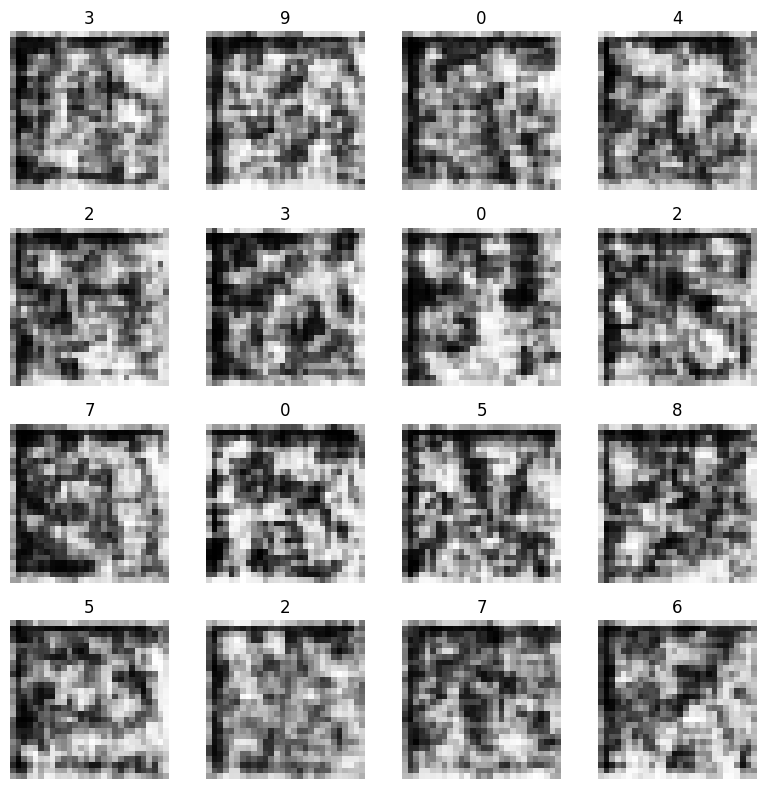

Step 1000 — D loss: 0.5924, G loss: 1.0898


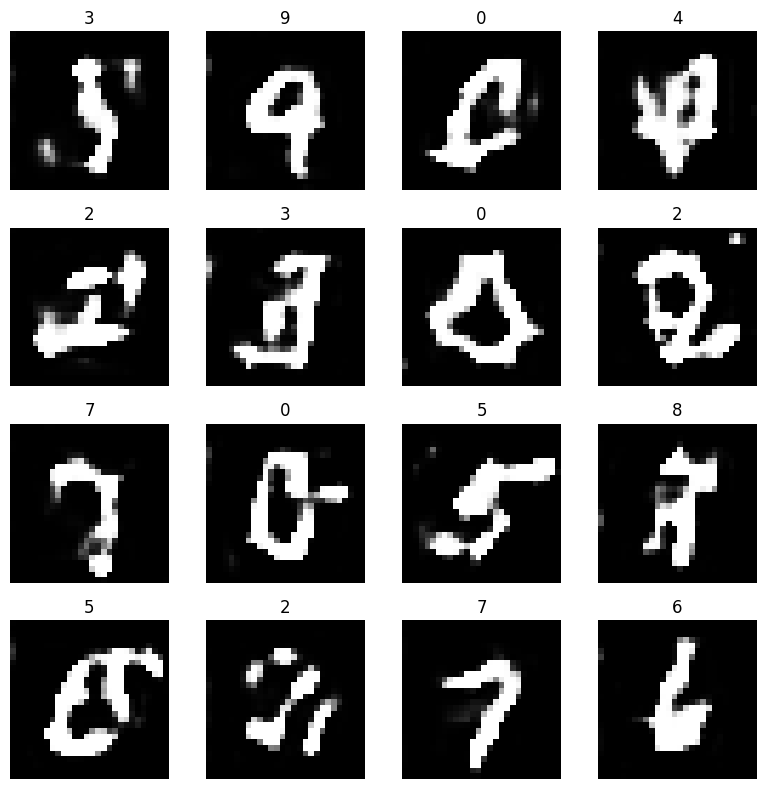

Step 2000 — D loss: 0.4602, G loss: 1.3194


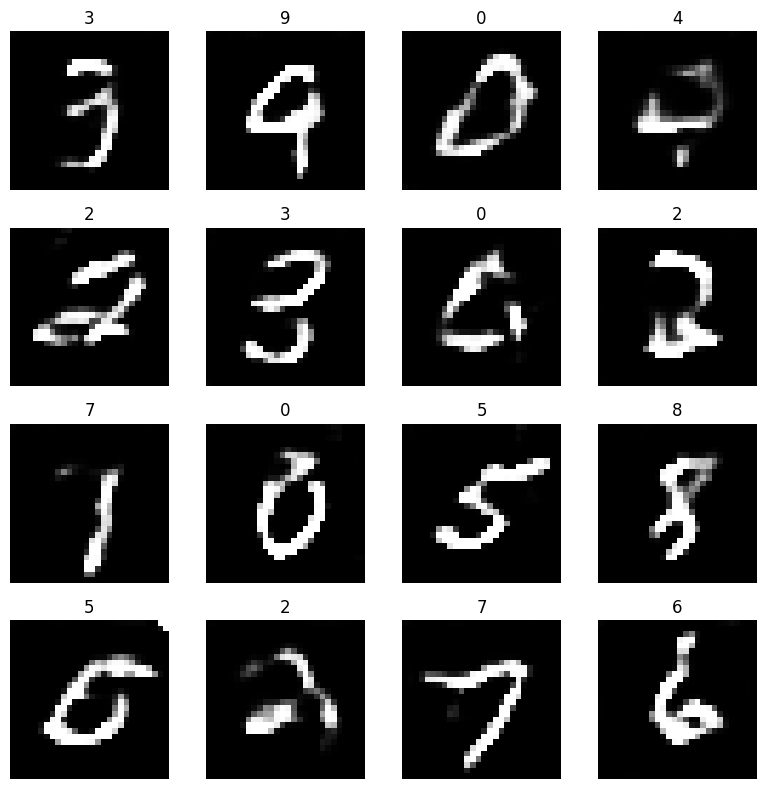

Step 3000 — D loss: 0.6802, G loss: 0.7913


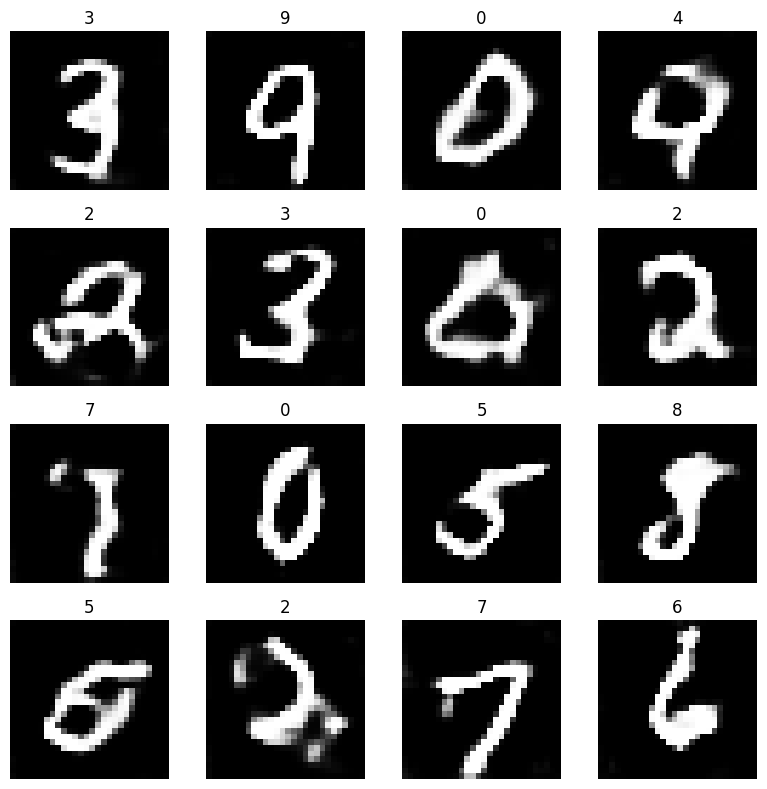

Step 4000 — D loss: 0.6820, G loss: 0.7949


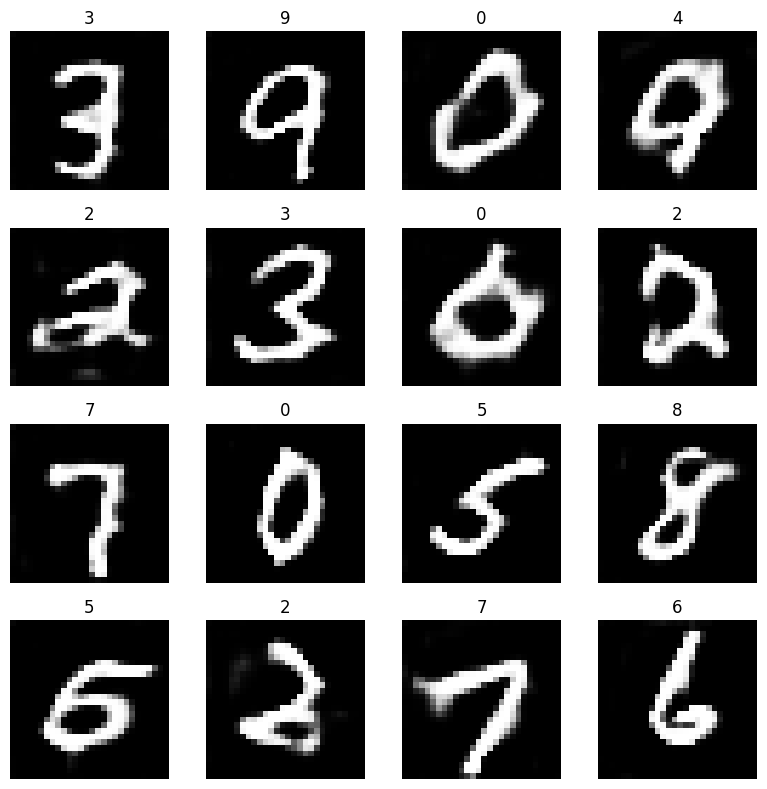

Step 5000 — D loss: 0.6144, G loss: 1.1902


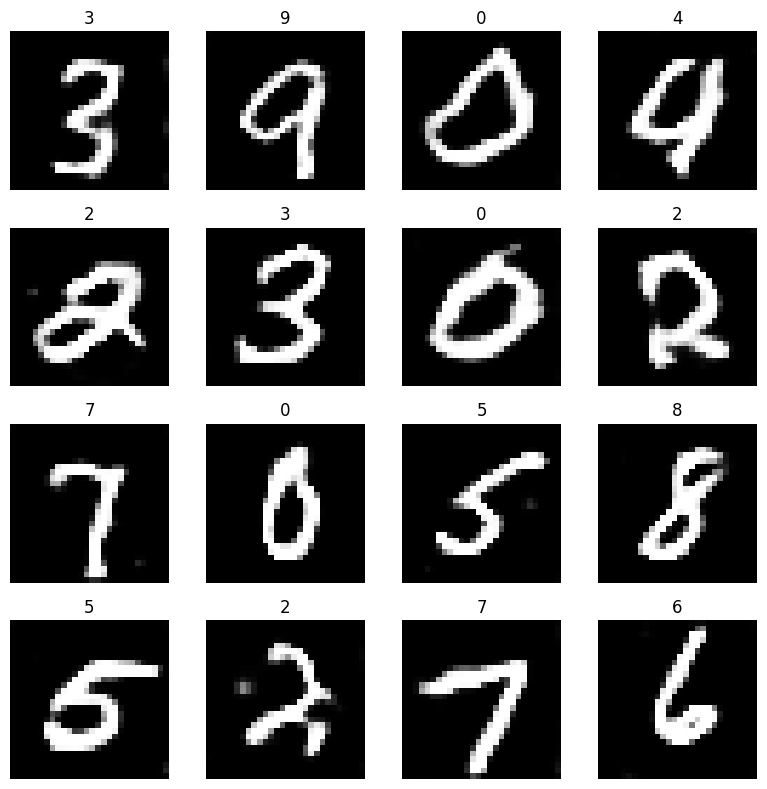

Step 6000 — D loss: 0.5765, G loss: 0.8435


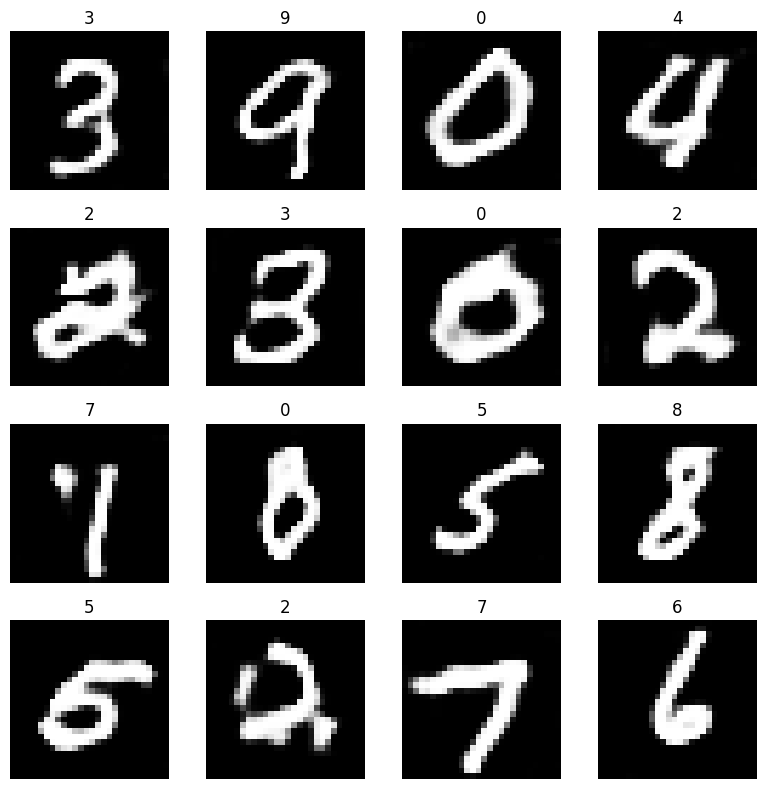

Step 7000 — D loss: 0.6215, G loss: 0.8900


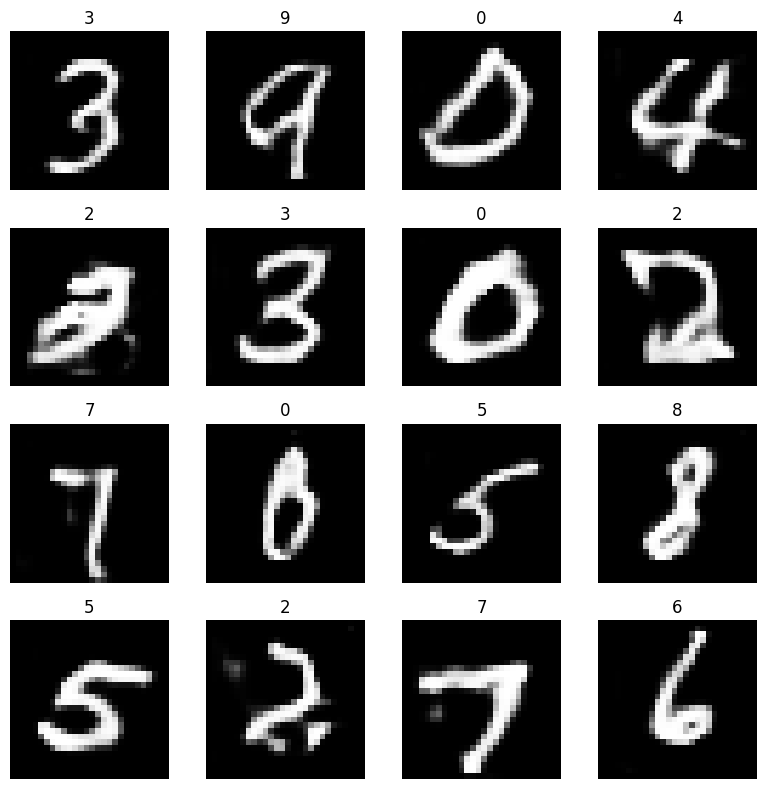

Step 8000 — D loss: 0.6035, G loss: 0.9133


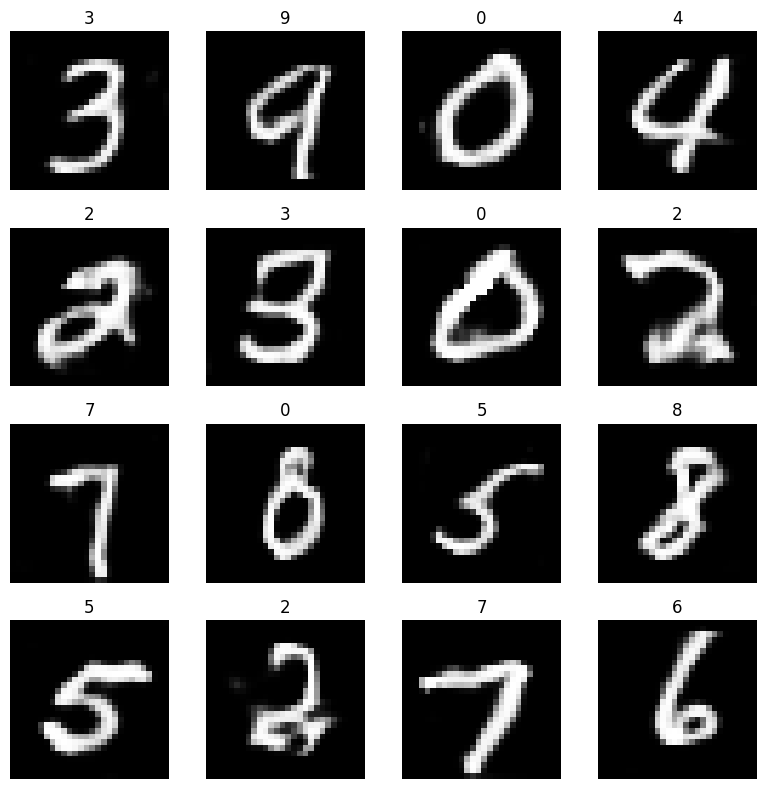

Step 9000 — D loss: 0.6097, G loss: 1.0728


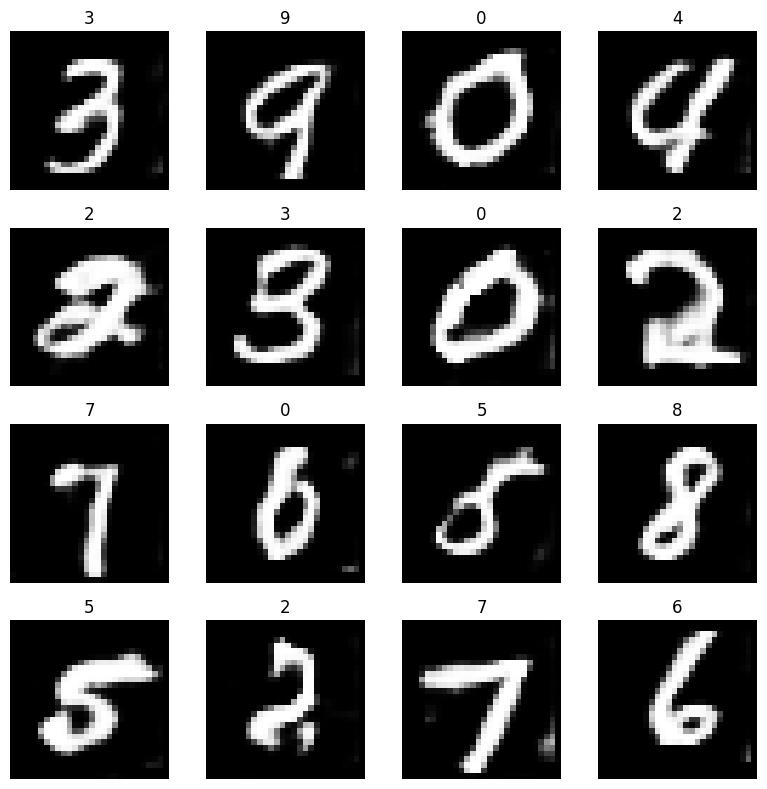

Step 10000 — D loss: 0.5810, G loss: 1.0540


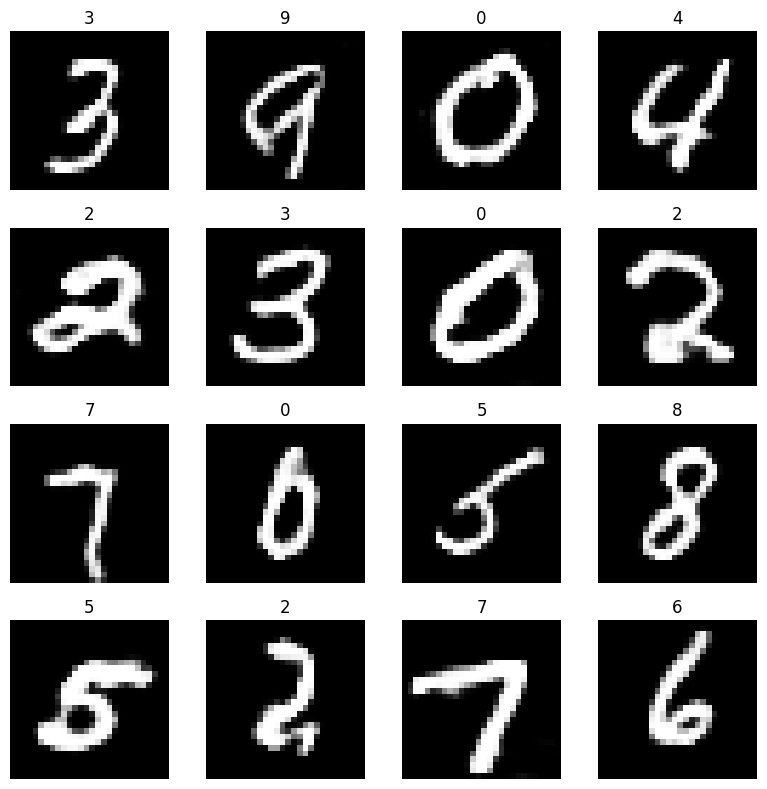

Step 11000 — D loss: 0.5706, G loss: 1.0678


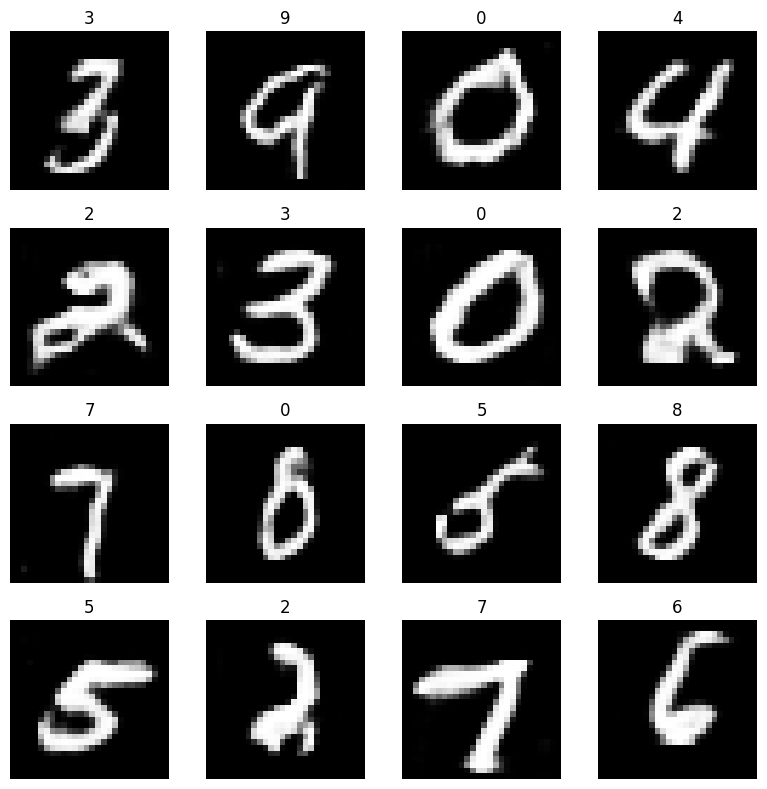

Step 12000 — D loss: 0.6609, G loss: 0.8569


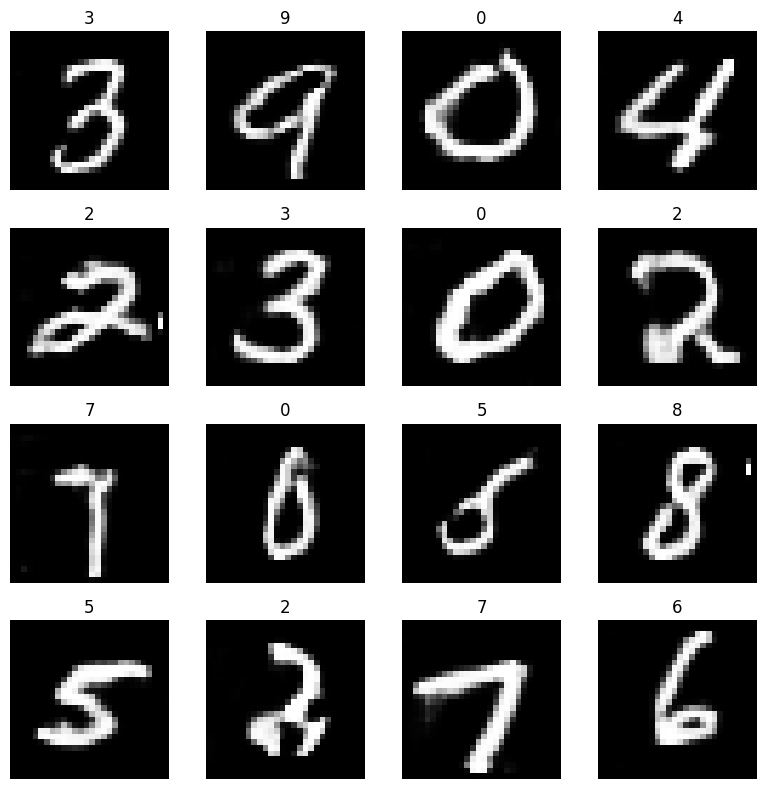

In [ ]:
def plot_image(images, labels, rows, cols):
    """Plots a grid of generated images with their class labels."""
    fig = plt.figure(figsize=(8, 8))
    for i in range(rows * cols):
        # Convert from (1, 28, 28) tensor to (28, 28) numpy for matplotlib
        img = images[i].detach().cpu().numpy().reshape(28, 28)
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(str(labels[i].item()))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    fig.tight_layout()
    plt.show()

def train_model():
    # Fixed test noise and labels — used every SAVE_INTERVAL to visualize progress
    samples_test = torch.randn(16, LATENT_DIM, device=device)
    labels_test = torch.randint(0, 10, (16, 1), device=device)

    losses = {"G": [], "D": []}

    # Label tensors reused every iteration — allocated once for efficiency
    real_labels = torch.ones(BATCH_SIZE, 1, device=device)
    fake_labels = torch.zeros(BATCH_SIZE, 1, device=device)

    # Create an infinite iterator over the DataLoader
    # When exhausted, it restarts automatically
    data_iter = iter(train_loader)

    for step in range(NUM_STEPS):

        # --- Get a real batch from DataLoader ---
        try:
            real_imgs, batch_labels = next(data_iter)
        except StopIteration:
            # DataLoader exhausted, restart it
            data_iter = iter(train_loader)
            real_imgs, batch_labels = next(data_iter)

        # Move to device and reshape labels to (batch, 1)
        real_imgs = real_imgs.to(device)
        batch_labels = batch_labels.unsqueeze(1).to(device)

        # --- Generate fake images ---
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        fake_imgs = g_model(noise, batch_labels)

        # --- Train Discriminator ---
        optimizer_d.zero_grad()

        d_real_out = d_model(real_imgs, batch_labels)
        d_loss_real = criterion(d_real_out, real_labels)

        d_fake_out = d_model(fake_imgs.detach(), batch_labels)
        d_loss_fake = criterion(d_fake_out, fake_labels)

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optimizer_d.step()

        # --- Train Generator ---
        optimizer_g.zero_grad()

        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_labels = torch.randint(0, 10, (BATCH_SIZE, 1), device=device)

        gen_imgs = g_model(z, gen_labels)
        g_out = d_model(gen_imgs, gen_labels)

        g_loss = criterion(g_out, real_labels)
        g_loss.backward()
        optimizer_g.step()

        # --- Logging ---
        losses["G"].append(g_loss.item())
        losses["D"].append(d_loss.item())

        if step % SAVE_INTERVAL == 0:
            print(f"Step {step} — D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")
            with torch.no_grad():
                results = g_model(samples_test, labels_test)
            plot_image(results, labels_test, 4, 4)

    return losses


losses = train_model()

# 7. Loss Reporting

---

In [ ]:
def plot_losses(losses):
    """Plots generator and discriminator losses over training steps."""
    plt.figure(figsize=(10, 5))
    plt.plot(losses["D"], label="Discriminator", alpha=0.7)
    plt.plot(losses["G"], label="Generator", alpha=0.7)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_losses(losses)

# 8. Per-class Grid

---

In [ ]:
def plot_per_class(g_model, rows_per_class=5):
    """Generates a grid with one column per digit class (0-9)."""
    fig, axes = plt.subplots(rows_per_class, 10, figsize=(15, 8))

    for digit in range(10):
        noise = torch.randn(rows_per_class, LATENT_DIM, device=device)
        labels = torch.full((rows_per_class, 1), digit, device=device)

        with torch.no_grad():
            images = g_model(noise, labels)

        for row in range(rows_per_class):
            img = images[row].cpu().numpy().reshape(28, 28)
            axes[row, digit].imshow(img, cmap='gray')
            axes[row, digit].axis('off')

            # Column headers on the first row only
            if row == 0:
                axes[row, digit].set_title(str(digit))

    fig.suptitle("Generated Samples Per Class", fontsize=14)
    fig.tight_layout()
    plt.show()

plot_per_class(g_model)

# 9. Evaluation

---

In [ ]:
def evaluate_model():
    """Computes FID and KID between real MNIST images and generated images."""

    # --- Initialize metrics ---
    # Both use Inception-v3 features internally
    # feature=2048 uses the final pooling layer (standard for FID/KID)
    fid = FrechetInceptionDistance(feature=2048).to(device)
    kid = KernelInceptionDistance(feature=2048, subset_size=100).to(device)

    # --- Prepare real images ---
    # Sample NUM_EVAL_SAMPLES random indices from the training set
    idx = np.random.randint(0, len(train_dataset), NUM_EVAL_SAMPLES)

    # Process in batches to avoid OOM
    batch_size = 256
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        batch_idx = idx[i:i + batch_size]

        # Stack real images: (batch, 1, 28, 28) in [-1, 1]
        real_batch = torch.stack([train_dataset[j][0] for j in batch_idx])

        # Inception expects 3-channel uint8 [0, 255] at minimum 299x299
        # Denormalize: [-1, 1] → [0, 1] → [0, 255]
        real_batch = ((real_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)

        # Convert grayscale to RGB by repeating the single channel 3 times
        real_batch = real_batch.repeat(1, 3, 1, 1)

        # Resize from 28x28 to 299x299 (Inception's expected input size)
        real_batch = torch.nn.functional.interpolate(
            real_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)

        # Feed real images into both metrics
        fid.update(real_batch, real=True)
        kid.update(real_batch, real=True)

    # --- Generate fake images ---
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        current_batch = min(batch_size, NUM_EVAL_SAMPLES - i)

        noise = torch.randn(current_batch, LATENT_DIM, device=device)
        labels = torch.randint(0, 10, (current_batch, 1), device=device)

        with torch.no_grad():
            fake_batch = g_model(noise, labels)

        # Same preprocessing: denormalize → RGB → resize
        fake_batch = ((fake_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        fake_batch = torch.nn.functional.interpolate(
            fake_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)

        fid.update(fake_batch, real=False)
        kid.update(fake_batch, real=False)

    # --- Compute scores ---
    fid_score = fid.compute().item()
    kid_mean, kid_std = kid.compute()

    print(f"FID: {fid_score:.2f}")
    print(f"KID: {kid_mean.item():.4f} ± {kid_std.item():.4f}")

    return fid_score, kid_mean.item(), kid_std.item()


fid_score, kid_mean, kid_std = evaluate_model()

# 10. Model Saving

---

In [ ]:
def save_models():
    """Saves generator and discriminator state dicts."""
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

    # torch.save() serializes the state_dict (all learned parameters)
    # This is the recommended way to save in PyTorch (saving the full model object)
    torch.save(g_model.state_dict(), os.path.join(MODEL_OUTPUT_PATH, f'{G_MODEL_NAME}.pt'))
    torch.save(d_model.state_dict(), os.path.join(MODEL_OUTPUT_PATH, f'{D_MODEL_NAME}.pt'))
    print("Models saved.")

save_models()

# 11. Single-Image Inference

---

In [ ]:
# Specify a digit from 0-9
digit = 6

# Generate a single image for the chosen digit
z = torch.randn(1, LATENT_DIM, device=device)
label = torch.tensor([[digit]], device=device)

# No gradient tracking needed during inference
with torch.no_grad():
    generated = g_model(z, label)

# Convert from (1, 1, 28, 28) GPU tensor to (28, 28) numpy array for plotting
img = generated[0].cpu().numpy().reshape(28, 28)
plt.imshow(img, cmap='gray')
plt.title(f"Generated digit: {digit}")
plt.axis('off')
plt.show()